### Bitcoin Pricing Analysis

This notebook will run through EDA, feature engineering and pricing analysis on Bitcoin. We will look at feature engineering and different forecast time scales to see if there is any signal there. This might be in vain due to the volatility of Bitcoin!

Based on Bitstamp exchange Bitcoin pricing data set from Kaggle:

Accessed: 2020/11/01

https://www.kaggle.com/mczielinski/bitcoin-historical-data

In [31]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from datetime import datetime as dt

from IPython.display import HTML, display

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data
from sklearn.compose import ColumnTransformer, make_column_transformer

# Classifiers
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost.core import CatBoostClassifier

# other
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    TimeSeriesSplit,
    KFold
)

from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Helper funcs:
from utils import PurgedGroupTimeSeriesSplit, plot_cv_indices

plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = (15, 8)

# For reloading helper files on change:
%load_ext autoreload
%autoreload 2


In [2]:
data = pd.read_csv(
    "data/bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv",
    parse_dates=["Timestamp"],
    date_parser=lambda x: pd.to_datetime(x, unit="s"),
    index_col="Timestamp",
)
data.columns = data.columns.str.lower().str.replace("[()]", "", regex=True)
data.index.rename("timestamp", inplace=True)
data.shape

(4572257, 7)

Fair bit of data! It is stored by minute frequency but thinking we'll aggregate to a more manageable prediction window (maybe even more stable).

In [3]:
data.head()

,open,high,low,close,volume_btc,volume_currency,weighted_price
timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.isna().sum()

open               1241716
high               1241716
low                1241716
close              1241716
volume_btc         1241716
volume_currency    1241716
weighted_price     1241716
dtype: int64

Lots of NA's! Let's see if it's just early pricing data. Look at how many data points are NA each month, each hour:

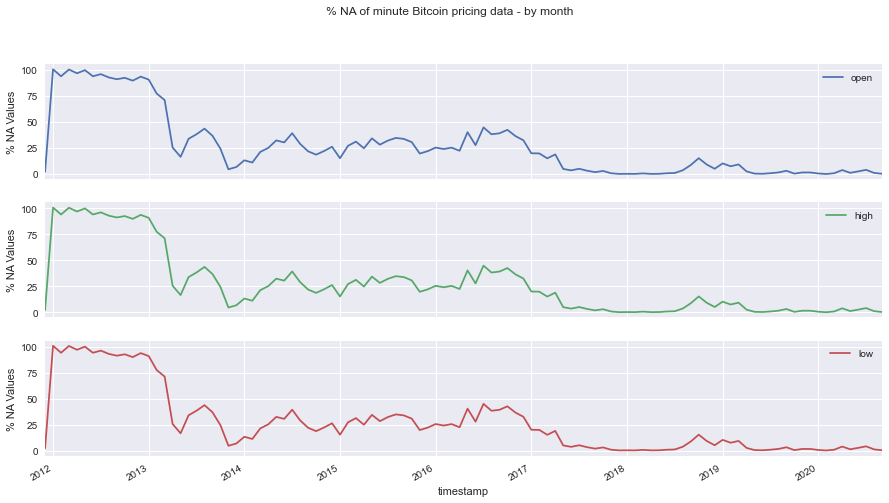

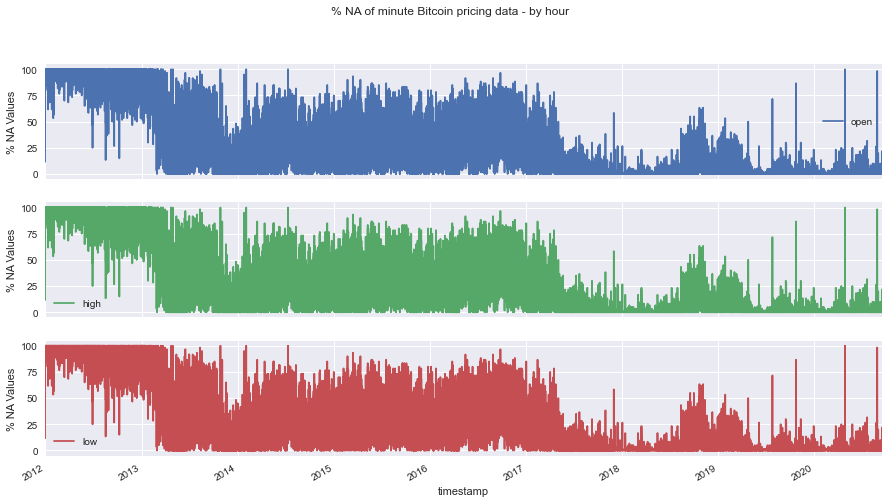

In [5]:
# For each month
(
    data.isna()
    .groupby(pd.Grouper(freq="M"))
    .sum()
    .apply(
        lambda x: 100 * x / (30.4 * 24 * 60)
    )[  # Calculate fraction of monthly values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by month",
        ylabel="% NA Values",
    )
)

(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )[  # Calculate fraction of hours reading values are NA
        ["open", "high", "low"]
    ]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour",
        ylabel="% NA Values",
    )
);

Ok - a fair bit of NA's to deal with. From the dataset page, this is noted as "no trades having occured". Potentially forward filling these should work then.

We should probably throw out data before ~ 2014. The Bitstamp exchange was founded in 2011 and potentially just didn't have the trade volumes until 2014. 

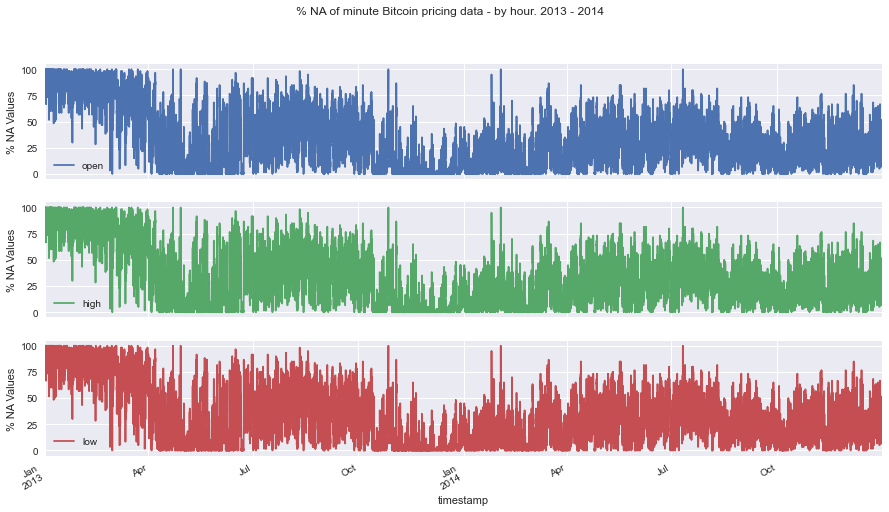

In [6]:
(
    data.isna()
    .groupby(pd.Grouper(freq="H"))
    .sum()
    .apply(
        lambda x: 100 * x / (60)
    )  # Calculate fraction of hours reading values are NA
    .query("index.dt.year == 2013 | index.dt.year == 2014")[["open", "high", "low"]]
    .plot(
        kind="line",
        subplots=True,
        title="% NA of minute Bitcoin pricing data - by hour. 2013 - 2014",
        ylabel="% NA Values",
    )
);

### Data Splitting and Filling

Let's get rid of the early data, and split into a test set here. We'll leak a bit of knowledge into our test set by splitting before the rebound in 2019, but the dataset after that point appears volatile and should be a relevant test set.

Early history (< 2017) is also before Bitcoin took off in the general public - have to see how/if the model can make effective use of this early data.

**We'll also carry forward to fill NA values for now.**

In [7]:
train_set_split_date = pd.to_datetime("2019/01/01")
start_date = pd.to_datetime("2014/01/01")

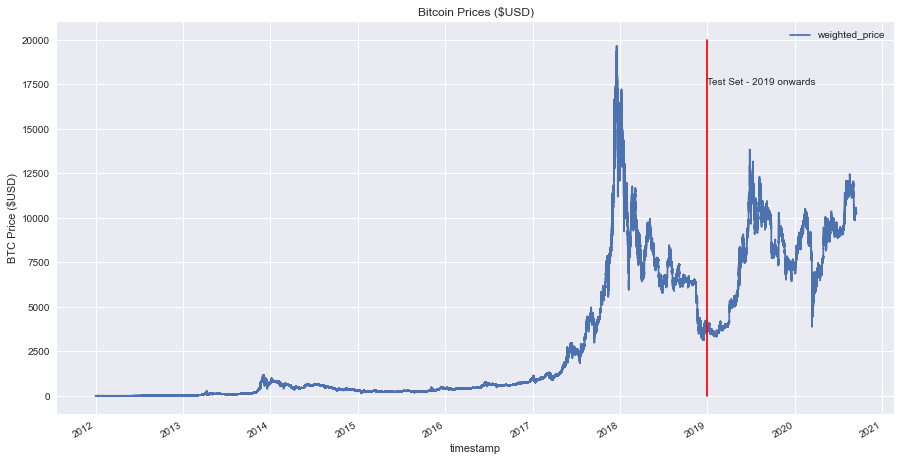

In [8]:
data.plot(
    kind="line",
    y="weighted_price",
    title="Bitcoin Prices ($USD)",
    ylabel="BTC Price ($USD)",
)
plt.plot([train_set_split_date, train_set_split_date], [0, 20000], "red")
plt.annotate("Test Set - 2019 onwards", (train_set_split_date, 17500));

In [9]:
data = data.loc[data.index > start_date].fillna(method="ffill")
train_df, test_df = (
    data.loc[data.index < train_set_split_date].dropna(),
    data.loc[data.index >= train_set_split_date].dropna(),
)

In [10]:
test_ratio = round(100 * test_df.shape[0] / (test_df.shape[0] + train_df.shape[0]), 1)
print(f"{test_ratio} % Test Split ")

25.5 % Test Split 


## Modelling

First lets get some baselines. How good could we do with bad forecasts? This can be captured by mean absolute scaled error (MASE [discussed here](https://robjhyndman.com/papers/forecompijf.pdf))  where we will scale by the errors made when just guessing the last known price. This means we evaluate MASE and if we are > 1, we are doing worse than guessing the last known price. Hopefully we can achieve values < 1, but as you step out to forecasting further time horizons (i.e hours or days ahead) this is harder to achieve.

This metric gives a better idea of how much skill we actually have in our forecast - if we look at the early time Bitcoin data, it would be pretty easy to guess the previous days price and be close to correct. In contrast, in the main Bitcoin bubble of 2017/2018 we would have some very bad predictions if we guessed the prior days price.

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin


def mase(y, y_pred):
    deltas = np.diff(y)
    d = np.abs(deltas[~np.isnan(deltas)]).sum() / y_pred.shape[0]
    errors = np.abs(y - y_pred)
    return errors.mean() / d


mase_scorer = make_scorer(mase, greater_is_better=False)


def plot_test_forecast(price_pred, price_actual, annotation):
    # Calculate the metric
    mase_predicted = round(mase(price_actual, price_pred), 2)

    # Show relative performance
    fig, ax = plt.subplots()
    price_pred.plot(ax=ax, label="Predicted")
    price_actual.plot(ax=ax, label="Actual")
    ax.annotate(annotation, xy=(0.75, 0.025), xycoords="figure fraction")
    ax.set_title(f"MASE: {mase_predicted}")
    ax.set_ylabel("Price ($USD)")
    ax.legend()

Lets pretend we were going to predict using a moving average and see how this stacks up on different volatility time periods. We'll look at the last year to get a baseline of MASE during more dramatic price movements. We'll also baseline against a narrower window with less volatility and see what MASE we can achieve.

In both cases, we'll use daily pricing for a simpler example.

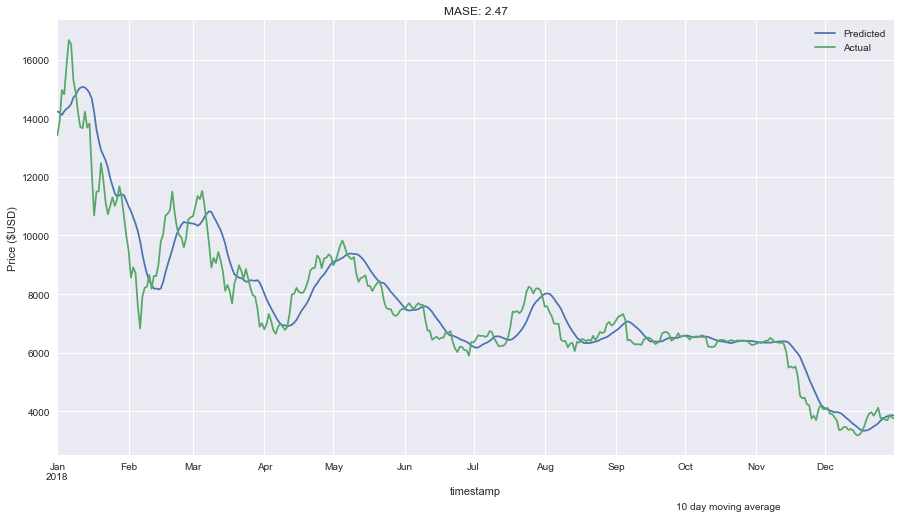

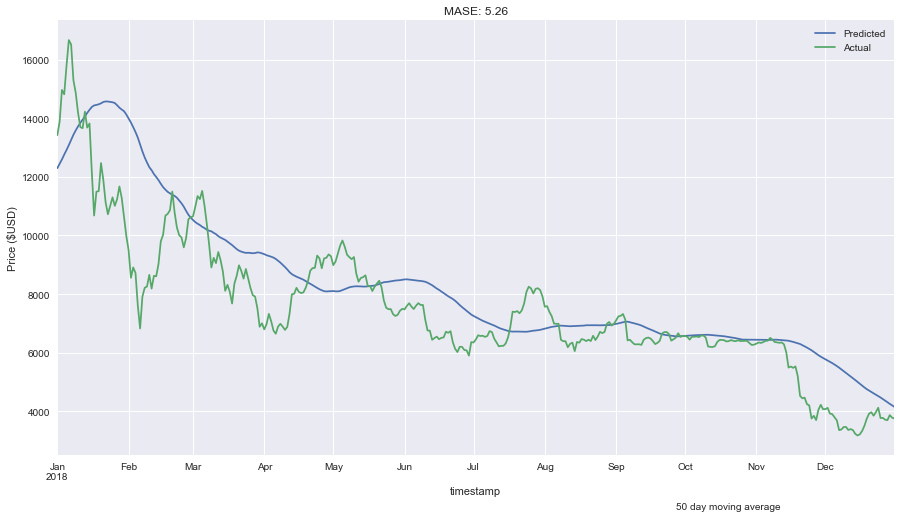

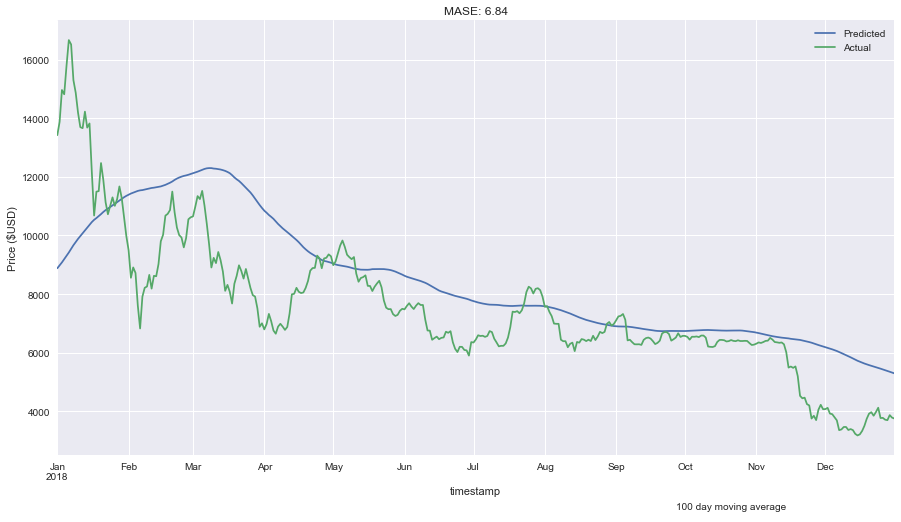

In [13]:
# Near end of dataset
num_steps = 365
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()

# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()
        .tail(num_steps),
        sample_df["weighted_price"].tail(num_steps),
        annotation=f"{win} day moving average",
    )

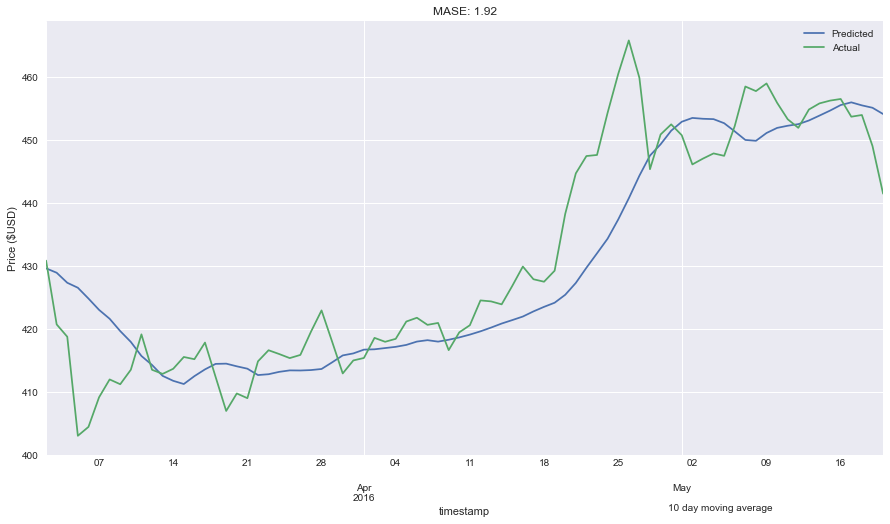

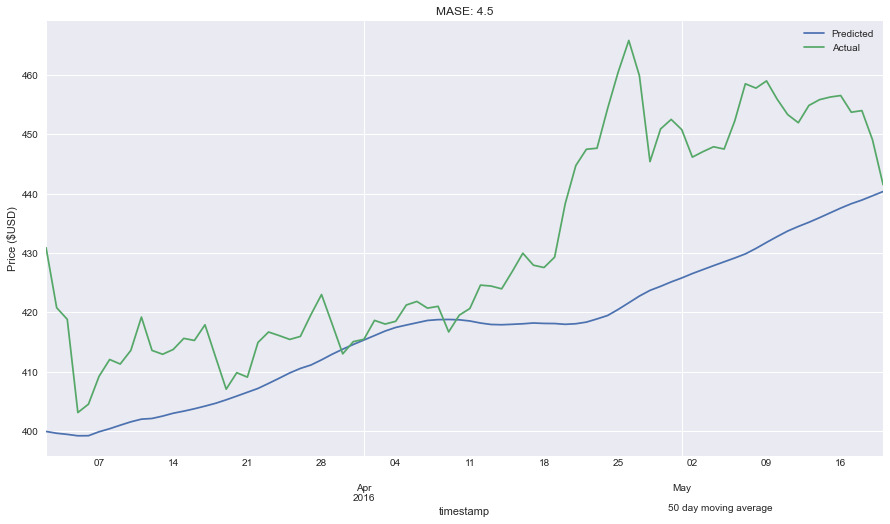

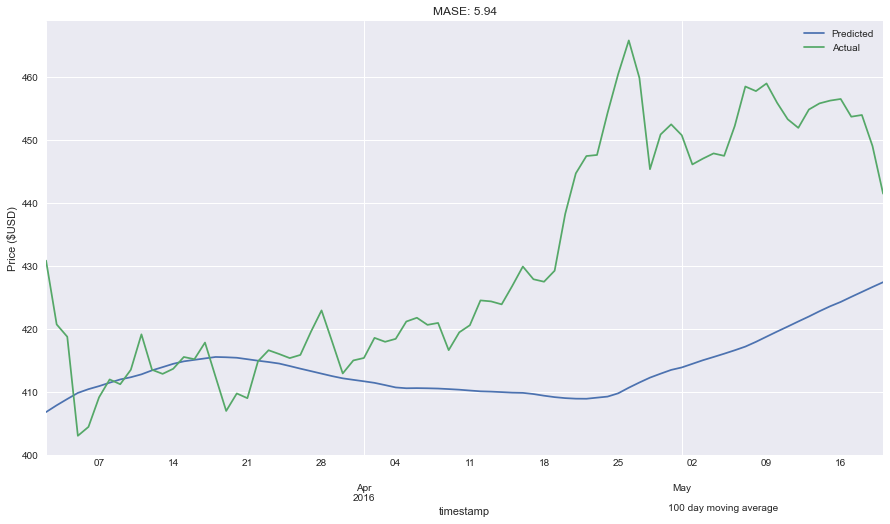

In [14]:
num_steps = 80
sample_df = train_df.groupby(pd.Grouper(freq="D")).mean()
start_date = "2016-03-01"

# Look at a smaller window in the middle with less volatility.
# Note - calculate rolling windows before filtering
for win in [10, 50, 100]:
    plot_test_forecast(
        sample_df["weighted_price"]
        .shift(1)
        .rolling(window=win, min_periods=0)
        .mean()[sample_df.index > start_date]
        .head(num_steps),
        sample_df.loc[sample_df.index > start_date, "weighted_price"].head(num_steps),
        annotation=f"{win} day moving average",
    )

Looks like aggregated to daily pricing, using simplistic moving averages calculated using previous pricing data, the best MASE we can achieve is ~ 1.9. This might change if we are trying to predict with less fidelity (i.e monthly pricing).

One more benchmark we can do - looking at different aggregation levels, how bad do we do if we guess the average price of the training data? Below we aggregate to hourly, daily, weekly and monthly average prices and try to predict on held out future data, using the mean training prices.

In [21]:
dummy_results = pd.DataFrame()
freqs = ["H", "D", "W", "M"]

for f in freqs:

    resample = train_df["weighted_price"].groupby(pd.Grouper(freq=f)).mean().dropna()

    res = cross_validate(
        DummyRegressor(),
        resample.shift(1),
        resample,
        cv=TimeSeriesSplit(n_splits=5),
        scoring=mase_scorer,
        return_train_score=True,
    )

    dummy_results[f"Frequency {f}"] = pd.DataFrame(res).mean()

dummy_results.rename(index={"test_score":"validation_score"})

,Frequency H,Frequency D,Frequency W,Frequency M
fit_time,0.001601,0.000200,0.001000,0.001000
score_time,0.001000,0.001000,0.001003,0.000541
validation_score,-175.997356,-31.484821,-11.627264,-5.767979
train_score,-98.468840,-19.144045,-6.930755,-2.945230


Ok, so no suprise here. Predicting the mean price over our training set ($E[Y|X]$) yields some bad results. Even on a monthly price, we are at a MASE of 2.95 (the negative is added by `sklearn` so we maximize this value).

Next we need to setup how we are going to validate our models. We can't just randomize and do K-fold validation as validation data that occurs in time before training data might leak information into our training set. This would mean we'd be subtly fitting any signals in the validation set that are meant to objectively test our model. So we want validation data to occur **after** training data. `sklearn` has this built in with `TimeSeriesSplit`. For a great discussion of the cross validation strategies in `sklearn` by default, see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html).

Here's the basic Kfold Validation visual:

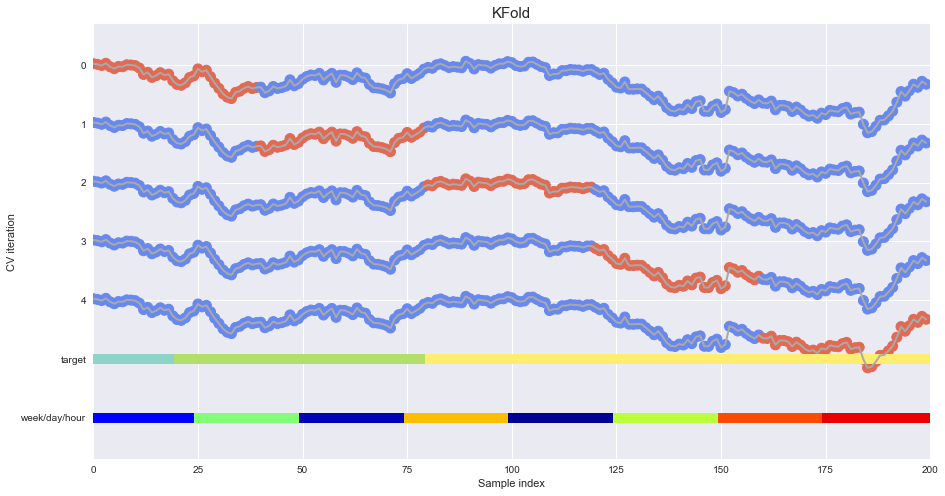

In [154]:
# CV Plotting code modified from:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html

# Generate the class/group data
n_points = 200
X_example = np.random.randn(n_points, 1)

percentiles_classes = [.1, .3, .6]
y_example = np.hstack([[ii] * int(n_points * perc)
               for ii, perc in enumerate(percentiles_classes)])

# Evenly spaced groups repeated once
n_groups = 8
groups = np.hstack([[ii] * int(n_points/n_groups) for ii in range(int(n_groups))])

n_splits = 5

fig, ax = plt.subplots()
cv1 = KFold(n_splits)

plot_cv_indices(cv1, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

And the `TimeSeriesSplit` style CV, notice how the validation set is always later than the training set:

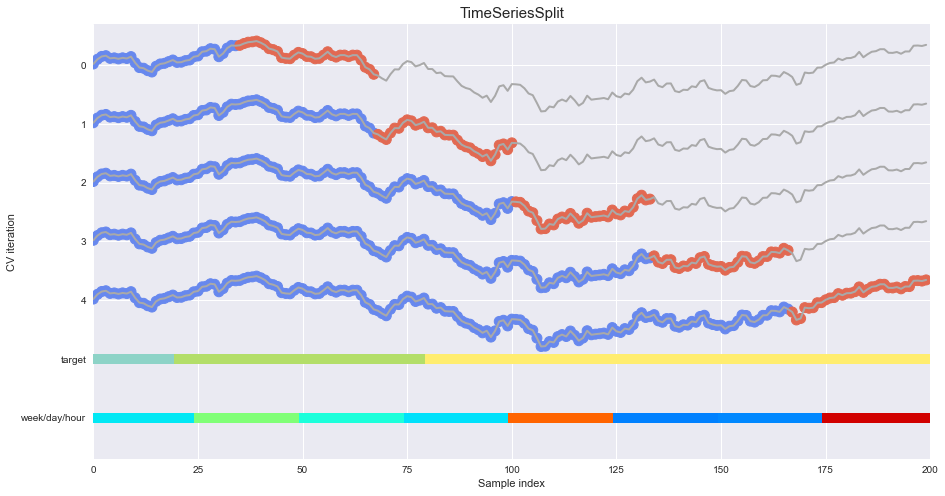

In [155]:
fig,ax=plt.subplots()
cv2 = TimeSeriesSplit(n_splits)
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour");

In the plots above the bottom row, "week/day/hour" shows how we want to maintain these groups when we do our splits. Concretely, we want to train on a certain set of days pricing, and validate on a completely separate set of days. 

The next concept that comes up is if we are calculating lagged terms such as moving averages, we want to ensure we have a gap between our validation data and our training set. At first this might not be so obvious, but if we look at a moving average with a decent window size we can see that our moving average is going to be carrying information from our training set into our validation set. 

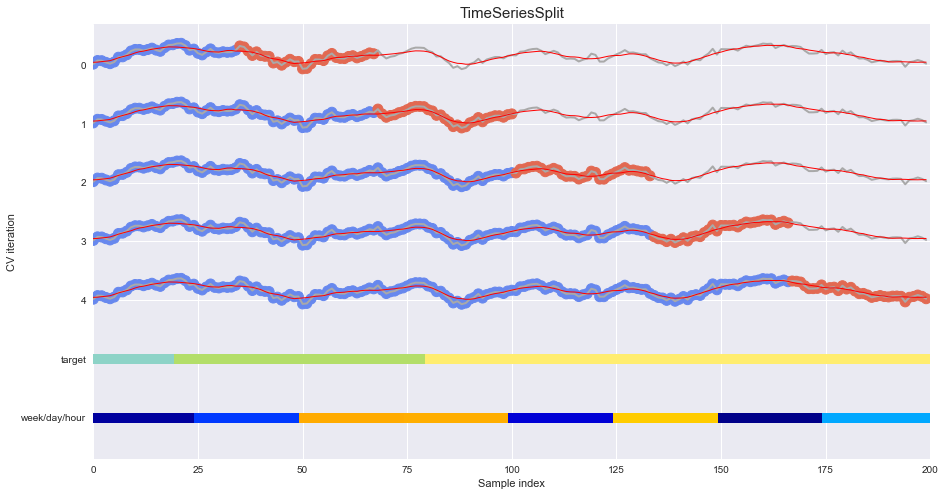

In [157]:
fig,ax=plt.subplots()
plot_cv_indices(cv2, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Notice how the moving average in red has trends in it that are carrying from the training set (blue) into the validation set (salmon?)...not good!

To solve both of these problems, we use a splitter that will honour a grouping column (i.e days) and will also build a gap in between training set and validation set to prevent carrying trends into the validation set. Thanks to the wonders of the internet (and Kaggle making it easier to share good ideas) - we can use a splitter built for `sklearn` from [here](https://www.kaggle.com/marketneutral/purged-time-series-cv-xgboost-optuna).

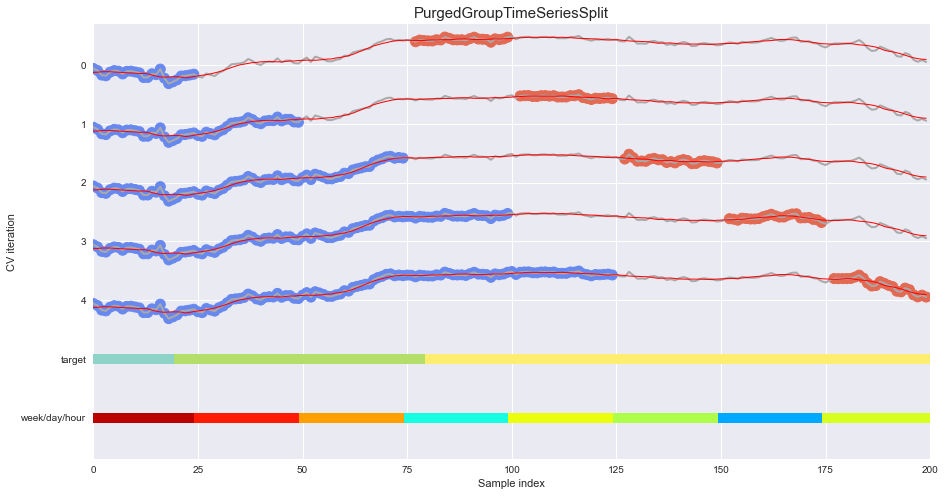

In [158]:
fig,ax=plt.subplots()
cv3 = PurgedGroupTimeSeriesSplit(n_splits, group_gap=2, max_train_group_size=30)
plot_cv_indices(cv3, X_example, y_example, groups, ax, n_splits,group_name="week/day/hour", moving_average=10);

Looks pretty good! All boundaries in our group column at the bottom are honored (i.e each day), and there is a gap between our train and validation sets. The gap width, and max training set size are parameters we need to double check depending on our fitting process. If we have a 100 day moving average being used we may want to have a larger gap than if we were using a 20 day moving average.

In [17]:
from tsfresh.examples import load_robot_execution_failures
from tsfresh.transformers import RelevantFeatureAugmenter


# Download dataset
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures
download_robot_execution_failures()

# pipeline = Pipeline([('augmenter', RelevantFeatureAugmenter(column_id='id', column_sort='time')),
#             ('classifier', RandomForestClassifier())])

df_ts, y = load_robot_execution_failures()
X = pd.DataFrame(index=y.index)